# Modeling and Electromagnetic simulation

In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np

import meent

In [3]:
pol = 0  # 0: TE, 1: TM

n_top = 1  # n_superstrate
n_bot = 1  # n_substrate

theta = 20 * np.pi / 180
phi = 50 * np.pi / 180

wavelength = 900

thickness = [500]
period = [1000]

fto = [30]

type_complex = np.complex128


## 1.1 Modeling

### ucell (unit cell)

ucell (unit cell) is a 3-dimensional array which has refractive index elements. It supports complex index, 2-dimensional grating and multi-layered structures.

The order of dimensions: Z Y X.


        ______________________
       |\                     \
       | \                     \  Y
       |  \                     \
       |\  \_____________________\
       | \ |      Layer 1        |
       \  \|_____________________|
        \  |                     | Z
         \ |      Layer 2        |
          \|_____________________|
                     X

* Z: Stack of the layers (1st axis of ucell)
   * In z-direction, layers (2D arrays) are stacked from top to bottom.
   * For example, ucell[0] is Layer 1 in the figure (2D array on the top) and ucell[1] is the next layer below.
* Y: Depth of the structure (2nd axis of ucell)
    * 2 dimensional grating is implemented on this and the last axes.
    * For 1 dimensional case, this is not used and fixed to 1.

* X: Width of the structure (3rd axis of ucell)
    * This is the default axis. 1 dimensional grating is implemented on this axis.



#### ucell examples

In [4]:
ucell_1d_s = np.array([
    [
        [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, ],
    ],
]) * 4 + 1  # refractive index

1D grating, single layer

In [5]:
ucell_1d_m = np.array([
    [
        [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, ],
    ],
    [
        [1, 1, 1, 1, 1, 0, 1, 0, 1, 0, ],
    ],
    [
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 1, ],
    ],
]) * 4 + 1  # refractive index

1D grating, multi layer

In [6]:
ucell_2d_s = np.array([
    [
        [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, ],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ],
    ],
]) * 4 + 1  # refractive index

2D grating, single layer

In [7]:
ucell_2d_m = np.array([
    [
        [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, ],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ],
    ],
    [
        [1, 1, 0, 1, 1, 0, 1, 0, 2, 1, ],
        [0, 1, 1, 1, 2, 4, 1, 0, 1, 1, ],
    ],
    [
        [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, ],
        [1, 1, 1, 2, 0, 1, 2, 0, 1, 1, ],
    ],
    [
        [0, 1, 0, 1, 1, 1, 1, 0, 1, 1, ],
        [0, 1, 3, 1, 1, 1, 1, 1, 1, 1, ],
    ],
]) * 4 + 1  # refractive index

2D grating, multi layer

### Wave

#### $\theta$: angle of incidence


          Incidence   normal
               \\      |
                \\     |
                 \\ 𝜃 (angle of incidence)     
                  \\   |
                   \\  |             
                    \\ |
                     \\|                       Z-axis
     ____________________________________        |
    |              Layer 1               |       |
    |____________________________________|       |_____ X-axis

#### $\phi$: azimuthal (rotation) angle

                      Plane of Incidence
                           /     |
                          /      |
                         /       |
                        /        |
                       /         |
                      /          |
                     /           |
                    /           /
                   /           /
           /      /           /                     /
          /      /           /  𝜙 (rotation angle) / 
         /      /      -----/------               /              
        /      /           /                     /  /            Y-axis  
       /      |           /                     /  /              /
      /_______|__________/_____________________/  / /            /
      |       |         /              Layer 1 | / /            /_____ X-axis
      |_______|________/_______________________|/ /             | 
      |       |       /               Layer 2  | /              |
      |_______|______/_________________________|/             Z-axis
              |     /

In 2D (projection on XY-plane),

    Y-axis   Plane of Incidence  
     |     // 
     |    //
     | 𝜙 // (rotation angle)
     |  //
     | //
     |//
     |--------------- X-axis
     |
     |

    

## 1.2 EM Simulation

In [8]:
mee = meent.call_mee(backend=0, pol=pol, n_top=n_top, n_bot=n_bot, theta=theta, phi=phi, fto=fto, wavelength=wavelength, period=period, ucell=ucell_1d_s, thickness=thickness, type_complex=type_complex)

call meent operator by `meent.call_mee`.
Here, backend can be selected with keyword `backend`

```python
backend = 0  # Numpy backend
backend = 1  # JAX backend
backend = 2  # PyTorch backend
```


### Diffraction Efficiency

#### Diffraction


      Incidence      Backward Diffraction 
                         (Reflected)
         ||               
         ||          -1th    0th    +1th
         ||          order  order   order
         ||             \     |     /
         ||          ... \    |    / ...
         ||               \   |   /   
         ||                \  |  /    n_top:refractive index of superstrate
     ____________________________________
    |              Layer 1               |
    |____________________________________|
                       .                        z-axis 
                       .                           |
                       .                           |
     ____________________________________          |_____ x-axis 
    |              Layer N               |
    |____________________________________|
                                     n_bot:refractive index of substrate
                           /  |  \    
                          /   |   \
                    ...  /    |    \  ...
                        /     |     \
               -2nd   -1th   0th    +1th   +2th
              order  order  order  order  order
              
                     Forward Diffraction 
                        (Transmitted)   

In [9]:
t0 = time.time()
de_ri, de_ti = mee.conv_solve()
print(f'time: ', time.time() - t0)

time:  0.11336421966552734


In [10]:
center = de_ri.shape[0] // 2

print('Diffraction Efficiency of Reflection:', np.round(de_ri[center-1:center+2], 3))
print('Diffraction Efficiency of Transmission:', np.round(de_ti[center-1:center+2], 3))

Diffraction Efficiency of Reflection: [[0.   ]
 [0.287]
 [0.   ]]
Diffraction Efficiency of Transmission: [[0.   ]
 [0.713]
 [0.   ]]


### Field Distribution

In [11]:
t0 = time.time()
field_cell = mee.calculate_field(res_z=100, res_y=1, res_x=100)
print(f'time: ', time.time() - t0)

time:  0.04631304740905762


#### ZX direction (Side View)

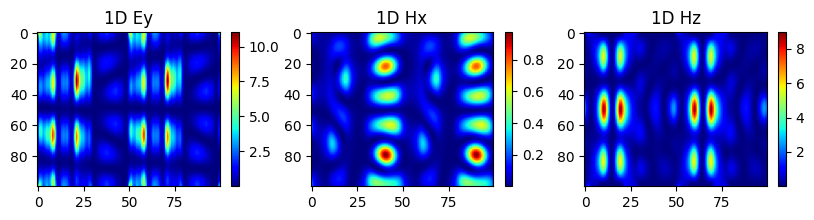

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(10,2))
if pol == 0:  # TE
    title = ['1D Ey', '1D Hx', '1D Hz', ]
else:  # TM
    title = ['1D Hy', '1D Ex', '1D Ez', ]

for ix in range(len(title)):
    val = abs(field_cell[:, 0, :, ix]) ** 2
    im = axes[ix].imshow(val, cmap='jet', aspect='auto')
    # plt.clim(0, 2)  # identical to caxis([-4,4]) in MATLAB
    fig.colorbar(im, ax=axes[ix], shrink=1)
    axes[ix].title.set_text(title[ix])

plt.show()

#### YZ Direction (Top View)

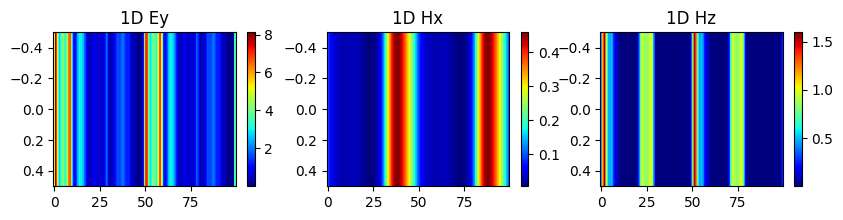

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(10,2))
if pol == 0:  # TE
    title = ['1D Ey', '1D Hx', '1D Hz', ]
else:  # TM
    title = ['1D Hy', '1D Ex', '1D Ez', ]

for ix in range(len(title)):
    val = abs(field_cell[0, :, :, ix]) ** 2
    im = axes[ix].imshow(val, cmap='jet', aspect='auto')
    # plt.clim(0, 2)  # identical to caxis([-4,4]) in MATLAB
    fig.colorbar(im, ax=axes[ix], shrink=1)
    axes[ix].title.set_text(title[ix])

plt.show()

## 1.3 Example: multilayer 2D

In [14]:
grating_type = 2
fto = [10, 9]
thickness = [100, 200, 400, 245]
period = [1000, 2000]

ucell_2d_m = np.array([
    [
        [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, ],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ],
    ],
    [
        [1, 1, 0, 1, 1, 0, 1, 0, 2, 1, ],
        [0, 1, 1, 1, 2, 4, 1, 0, 1, 1, ],
    ],
    [
        [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, ],
        [1, 1, 1, 2, 0, 1, 2, 0, 1, 1, ],
    ],
    [
        [0, 1, 0, 1, 1, 1, 1, 0, 1, 1, ],
        [0, 1, 3, 1, 1, 1, 1, 1, 1, 1, ],
    ],
]) * 4 + 1  # refractive index


In [15]:
mee = meent.call_mee(backend=0, pol=pol, n_top=n_top, n_bot=n_bot, theta=theta, phi=phi, fto=fto, wavelength=wavelength, period=period, ucell=ucell_2d_m, thickness=thickness, type_complex=type_complex)

In [16]:
t0 = time.time()
de_ri, de_ti = mee.conv_solve()
print(f'time: ', time.time() - t0)

time:  10.542928695678711


In [17]:
center = de_ri.shape[0] // 2

print('Diffraction Efficiency of Reflection:\n', np.round(de_ri[center-1:center+2, center-1:center+2], 3))
print('Diffraction Efficiency of Transmission:\n', np.round(de_ti[center-1:center+2, center-1:center+2], 3))

Diffraction Efficiency of Reflection:
 [[0.028 0.056 0.   ]
 [0.183 0.036 0.   ]
 [0.    0.    0.   ]]
Diffraction Efficiency of Transmission:
 [[0.063 0.004 0.   ]
 [0.025 0.052 0.   ]
 [0.    0.    0.   ]]


In [18]:
t0 = time.time()
field_cell = mee.calculate_field(res_z=40, res_y=40, res_x=40)
print(f'time: ', time.time() - t0)

time:  3.1625919342041016


#### ZX direction (Side View)

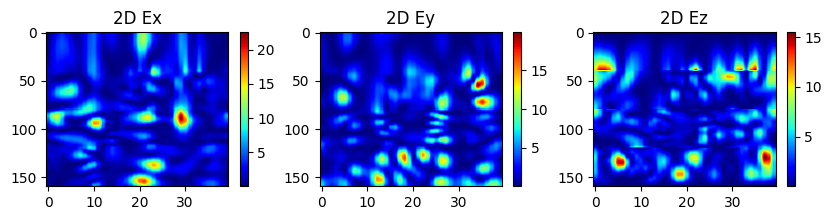

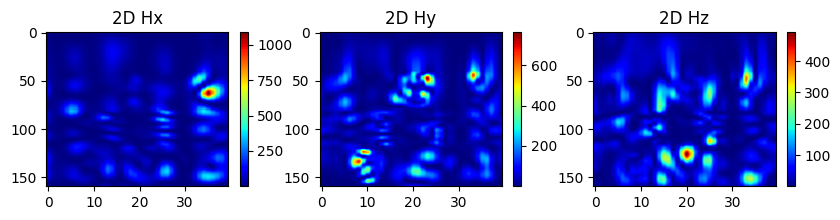

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(10, 2))
title = ['2D Ex', '2D Ey', '2D Ez', '2D Hx', '2D Hy', '2D Hz', ]

for ix in range(3):
    val = abs(field_cell[:, 0, :, ix]) ** 2
    im = axes[ix].imshow(val, cmap='jet', aspect='auto')
    # plt.clim(0, 2)  # identical to caxis([-4,4]) in MATLAB
    fig.colorbar(im, ax=axes[ix], shrink=1)
    axes[ix].title.set_text(title[ix])

plt.show()

fig, axes = plt.subplots(1, 3, figsize=(10, 2))
for ix in range(3, 6, 1):
    val = abs(field_cell[:, 0, :, ix]) ** 2
    im = axes[ix-3].imshow(val, cmap='jet', aspect='auto')
    # plt.clim(0, 2)  # identical to caxis([-4,4]) in MATLAB
    fig.colorbar(im, ax=axes[ix-3], shrink=1)
    axes[ix-3].title.set_text(title[ix])

plt.show()

#### YZ Direction (Top View)

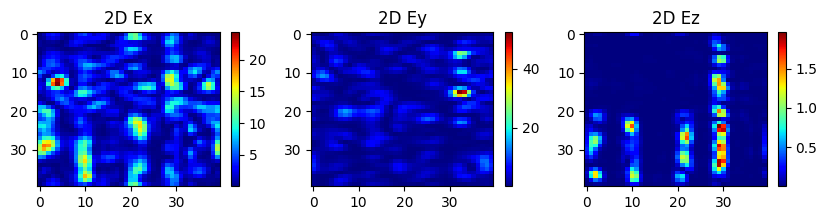

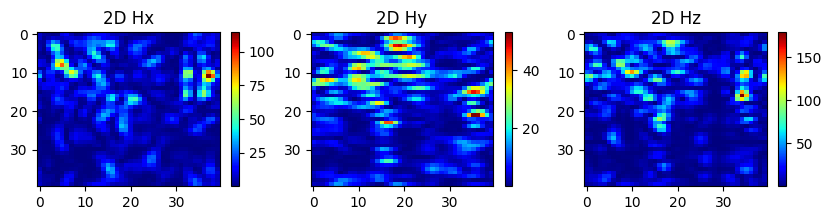

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(10, 2))
title = ['2D Ex', '2D Ey', '2D Ez', '2D Hx', '2D Hy', '2D Hz', ]

for ix in range(3):
    val = abs(field_cell[0, :, :, ix]) ** 2
    im = axes[ix].imshow(val, cmap='jet', aspect='auto')
    # plt.clim(0, 2)  # identical to caxis([-4,4]) in MATLAB
    fig.colorbar(im, ax=axes[ix], shrink=1)
    axes[ix].title.set_text(title[ix])

plt.show()

fig, axes = plt.subplots(1, 3, figsize=(10, 2))
for ix in range(3, 6, 1):
    val = abs(field_cell[0, :, :, ix]) ** 2
    im = axes[ix-3].imshow(val, cmap='jet', aspect='auto')
    # plt.clim(0, 2)  # identical to caxis([-4,4]) in MATLAB
    fig.colorbar(im, ax=axes[ix-3], shrink=1)
    axes[ix-3].title.set_text(title[ix])

plt.show()